In [5]:
%matplotlib inline

In [6]:
import pathlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D
import mpl_toolkits.mplot3d

import skimage
import skimage.io

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Principle Component Analysis
## 1. Introduction

This notebook investigates Principle Component Analysis (PCA): what is it and what is it used for. Let's start by developing an intuition what PCA does.

Consider a table with math and physics scores for a class of 30 students. Lets plot math scores on $x$ and physics scores on $y$.

The left plot below (not all 30 points are drawn) shows the case if all studets have the same exact score on the math test. Then, there will be no variation on the x axis as there is a single value. The right graph is more realistic - the scores for both subjects have some variation.

<div>
<img src="images/2022-06-15 14_11_13.png" width="600">
</div>

**PCA is an algorithm** from linear algebra. It finds a new coordinate system that fits the data better than the original axes. This is not the most professional way to define PCA but our aim now is create intuition. We will later look at more formal definitions.

For example, consider the surprising case when all student scores for maths and physics are the same: (52,52), (78, 78)... Then PCA would create a coordinate system as show on the left plot below. The new BLUE axis would capture all varation from the dataset.

Note that while the old axes - $x$ and $y$ - have meaning (that is math and physics grades), it may be difficult to express the new blue PCA axis in words. The new axes (blue and green) are called **principle components**.

<div>
<img src="images/2022-06-15 14_11_51.png" width="800">
</div>


Q: Why is this new coordinate system useful?

A: In data science, we often use data to create a model and make predictions based on this model. Also, the number of variables are not just 2 as in the example above, but e.g. 10...30000. Dealing with many variables causes all sorts of issues, to name a few: 
* model may become too complex -> PCA reduces the number of variables thus the model complexity
* avoid model overfitting
* curse of dimensionality

Now that we posses some feeling on what PCA does, we can also define it more formally. There may be different definitions depending on the prospective:

How linear algebra / math sees it:
> PCA is the process of computing the principal components and using them to perform a change of basis on the data, sometimes using only the first few principal components and ignoring the rest (source: [wikipedia](https://en.wikipedia.org/wiki/Principal_component_analysis))

> Linear dimensionality reduction using Singular Value Decomposition of the data to project it to a lower dimensional space. (source: [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html))

## 2. Background concepts
### Dataset

There are some prerequsites neccessary to understand how PCA works. Let's describe the main concepts and get some intuitions. A full understanding of all related topic is too difficult and is outside the scope of this project.

PCA is applyed on data. However, the data format or way it is arranged is not random: data is represesnted as a dataset.

A **dataset** is collection of data arranged in a 2D table (matrix). It has **rows** and **columns**. Each row is a single measurement (called **record**) and each column holds one characteristic (called **variable**).

Let's look at an example: a dataset containing measurements of Italian wines. Full description is in this [link](https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.index). Some parts of the description are quoted below to make you aware of the main contex:

> These data are the results of a chemical analysis of
> wines grown in the same region in Italy but derived from three
> different cultivars.
> The analysis determined the quantities of 13 constituents
> found in each of the three types of wines. 

The variables include both substances such as alcohol, ash, and magnesium and properties of the wine - color intensity and hye. Each record is a measurement of a single bottle of wine. As described above, variables are in the dataset columns, records - in the rows. Rach row has a name or id, the set of all names or ids is called **index**. Each column also contains the name of the variable, all names are called **header**.

It is critical to know how data is formatted and what the various terms mean to comprehend PCA. Be aware there are multiple words for the same thing (expecially useful to make sense of reading aricles online):
* record is also called entry
* variable is also called feature

There is one final column we have not discussed yet - the target. To understand its meaning, it is helpful to first discuss the notion of predictive analysis.

**Predictive analysis** is the action of using data and algorithms to calculate likelyhood of future outcomes based on historycal data.

The **target** is a column with the outcomes we try to predict.

In the example above, the first column contains the variety of wine. The name is however not included as text, but is rather **encoded** that is represented as a number. In our dataset there are 3 unique numbers: 0, 1 and 2. Unfortunatelly, our dataset description does not specify the variety; let's assume the varieties are Chardone, Merlot, Cabernet Franc. 

The target is also called response or output. That is because the purpose of the predictive analysis is, not surprisingly, to predict the wine variety based on its characteristics. The terms below make sense in this contex:
* feature = column in the dataset = **input**
* target = column in the dataset = **output** = **response**

Data is modified well using Linear Algebra. In this context, each feature is viewed as a dimension or axis; record is viewed as a vector with components (coordinates) in those axes. We say the vectors are in space $R^n$ where $n$ is the number of dimensions. In the wine example, there are 172 vectors in space $R^13$. Thus each vector (meaning each wine) has 13 dimensions (wine characteristics).
* feature = **dimension**
* target = **vector**

After the detailed review above, let's open a data set. You can also notice that the features are also encoded.

In [7]:
wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
wine.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


The main terms are as shown below:
<div>
    <img src="images/2022-06-15 14_25_42.png" width="500"/>
</div>

### Normalization

Normalization is a procedure performed on data. It is comprised of two other procedures: centering and scaling.

Centering is making the mean 0. This is done by subracting the mean of each variable from each entry.

Scaling (as constituent of normalization) is making the standard deviation 1.

The change is denoted by the z-score.

<div>
<img src="images/2022-06-15 15_20_46.png" width="500">
</div>

### Eigenvalues and eigenvectors

Lets look a following 2D example.

Let $A$ be a random 2x2 matrix. If we multipy a vector $\vec x = \begin{bmatrix} 1 \\ 2 \end{bmatrix}$ by $A$ (or any vector for that matter), the vector will be sent to a "new place" in the xy plane. Technically speaking, we are treating $A$ as a matrix of a linear tranformation:

$$ A \vec x = \vec b $$

We can first write a helper function that plots vectors.

In [15]:
def plot_radius_vectors(vectors, colors):
    """
    Plots 2D radius vectors on the xy-plane. Each vector is in the format (end_x, end_y).
    """
    # Extract vector coordinates
    flattened = np.array(vectors).ravel()
    end_x, end_y = flattened[::2], flattened[1::2] 

    # Plot an arrow
    start_x = np.zeros(end_x.shape)
    start_y = np.zeros(end_x.shape)
    plt.quiver(start_x, start_y, end_x, end_y, scale=1, scale_units='xy', angles = "xy", color=colors)

    # Make the plot pretty (housekeeping)
    all_x = np.concatenate((start_x, end_x))
    all_y = np.concatenate((start_y, end_y))
    min_x, max_x = min(all_x), max(all_x)
    min_y, max_y = min(all_y), max(all_y)
    correction = 1
    plt.xlim(min_x - correction, max_x + correction)
    plt.ylim(min_y - correction, max_y + correction)

Then, lets define a matrix and make the matrix act on the vector (transform it).

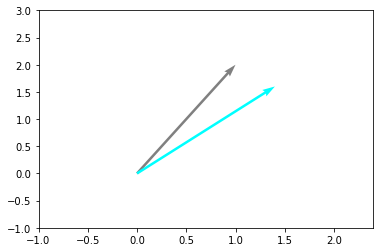

In [16]:
A = np.array([
    [0.8, 0.3],
    [0.2, 0.7],
])

x = np.array([1, 2])
b = A @ x
plot_radius_vectors([x, b], colors=['gray', 'aqua'])

The new vector $ \vec b $ (in teal color) has "moved". We can further transform $ \vec b $ to see how it would change if transformed further: 

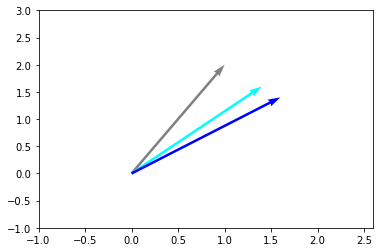

In [17]:
plot_radius_vectors([x, b, A @ b], colors=['gray', 'aqua', 'blue'])

The new blue vector has moved again.

Let's try another vector: $\vec x = \begin{bmatrix} -1 \\ 1 \end{bmatrix}$:

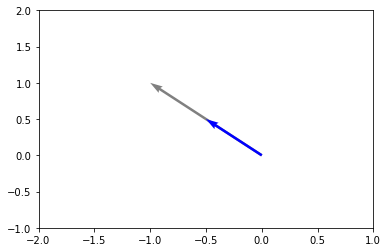

In [18]:
x = np.array([-1, 1])
b = A @ x
plot_radius_vectors([x, b], ['gray', 'blue'])

Well, that is interesting, the two vectors seem to lie on the same line. $\vec{x}$ does not change direction when multoplied by $A$. Is this a coincidence?

Acutually not: I chose  $ \begin{bmatrix} -1 \\ 1 \end{bmatrix}$ on purpose. I knew what would happen in advance. Let's look deeper and compare the distances of the two vectors.

In [19]:
x_len = np.sqrt(x @ x)
b_len = np.sqrt(b @ b)
b_len / x_len

0.49999999999999994

It seems that the new blue vector has shrunk in half.
Here comes a sensible question: are there more of these "special" vectors with the same behavior? Also, how can those be calculated?

Let's write the transformation from above:
$$ A \vec{x} = \vec{b} = 0.5 \vec{x}$$

Vectors that are scaled as $\vec{x}$ is are called **eigenvectors**. Formally stated, $\vec{x}$ is an eigenvector if it lies along the same line as $A \vec{x}$. We call $0.5$ an **eigenvalue**. Eigenvalues are commonly denoted with $\lambda$.

Note that $\vec{x} = \begin{bmatrix} -1 \\ 1 \end{bmatrix}$ BELONGS to $A$. $\vec{x}$ may not be eigenvector of other matrixes.

### Projection

Projection of a vector on another vector can be viewed from different prospectives. The most intuitive way is the 2d geometrical case.

<div>
    <img src="images/2022-06-15 15_25_45.png" width="300">
</div>

From the prospective of the linear algebra, projection is a transformation, more specifically - linear operator.
As any other transformation, the projection has a matrix. Multiplying this matrix with a vector causes the vector to "move" to a new location. In the 2d example above, the location is a single vector. The projection basically compresses the 2D space to a line.

The projection matrix that "sends" $\vec{b}$ to $\vec{p}$ is (the vector notation arrows are omitted on perpose):
$$ P = \frac{aa^T}{a^Ta} $$
$$ Pb = p $$

Consider the example below. We will be projecting the RED vector $\vec a$ over the GRAY $\vec b$. 

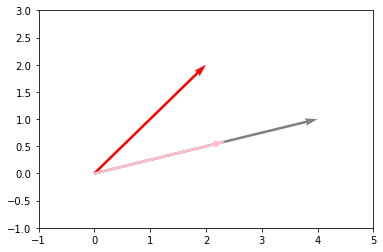

In [23]:
a = np.array([
    [4],
    [1],
])
b = np.array([
    [2],
    [2],
])


def calc_projection(a):
    """
    Returns the projection matrix to project on vector `a`.
    """
    return (a @ a.T) / (a.T @ a)

# Projection matrix (rank 1)
P = calc_projection(a)
b_projection = P @ b
plot_radius_vectors([a, b, b_projection], ['grey', 'red', 'pink'])
plt.show()

The projection matrix projects any vector $\vec{b}$ onto the line $\vec{a}$ is lying on. Basically, the 2d space is compressed in a single line (from 2 to 1 dim).

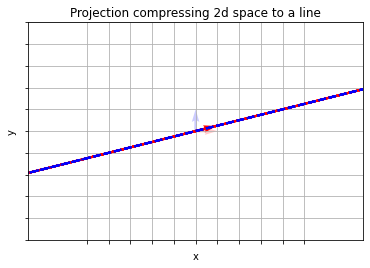

In [26]:
def visualize_transformation(matrix, plot_title):
    """
    Visualize the 2D linear transformation with transformation `matrix`.
    Plots the current (before) and newgrid (after the transformation).
    """
    # Create new figure
    fig = plt.figure()
    ax = fig.add_subplot()
    plt.axis("equal")
    
    # Modify tranformation matrix to work with Affine2D
    modified = np.concatenate((matrix, np.zeros((2,1))), axis = 1)
    modified = np.concatenate((modified, [[0, 0, 1]]),axis=0)
    
    # Current unit vectors and grid
    ax.quiver([0, 0], [0, 0], [1, 0], [0, 1], color = ["red", "blue"], alpha = 0.2, units = "xy", scale = 1)
    ax.grid()
    
    # Transform the space
    t = Affine2D(modified)
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
    [min_x, max_x, min_y, max_y] = [2 * ax.get_xlim()[0], 2 * ax.get_xlim()[1] + 1, 2 * ax.get_ylim()[0], 2 * ax.get_ylim()[1] + 1]
    
    # New grid lines
    # Horizontal
    for y in np.arange(min_y, max_y):
        ax.plot([min_x, max_x], [y] * 2, color = "red", linestyle = "--", linewidth = 2, transform = t + ax.transData)
    # Vertical
    for x in np.arange(min_x, max_x):
        ax.plot([x] * 2, [min_y, max_y], color = "blue", linestyle = "--", linewidth = 2, transform = t + ax.transData)

    # New unit vectors
    new_x = t.transform_affine([1, 0])
    new_y = t.transform_affine([0, 1])
    ax.quiver([0, 0], [0, 0], [new_x[0], new_y[0]], [new_x[1], new_y[1]], color = ["red", "blue"], units = "xy", angles = "xy", scale = 1)
    
    # Make the plot pretty (housekeeping)
    ax.set_xticks(np.arange(ax.get_xlim()[0], ax.get_xlim()[1] + 1))
    ax.set_yticks(np.arange(ax.get_ylim()[0], ax.get_ylim()[1] + 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])  
    ax.set_title(plot_title)
    

visualize_transformation(P, "Projection compressing 2d space to a line")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Note that the selection of $\vec{a}$ is not affecting the projection $\vec{p}$. This makes sense as $\vec{a}$ was chosen at random and also because the projection is **on the line** that $\vec{a}$ lies on. 

Let's run some code to test this statement. As you can see below, the projection remains correct despite that $\vec{a}$ was changed.

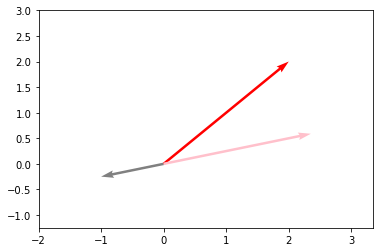

In [27]:
a = np.array([
    [-1],
    [-0.25],
])
P = ((a @ a.T) / (a.T @ a))
p = P @ b
plot_radius_vectors([a, b, p], ['grey', 'red', 'pink'])

### Matrix Factorization

To **factorize** or **decompose** a matrix is the action of representing it as a product of several matrices. The corresponding processes are unsurprisingly called matrix factorization and matrix decomposition.

Matrix **diagonalization** is a specific case of factorization. While factorization allow any matrixes in the product, diagolizing $A$ has to result in the following specific type: $A=PDP^{-1}$. If $A$ can be diagonalized, it is called diagonalizable. Only square $A$ can be diagonalized.

The diagram below shows some factorizations. As PCA is based on the singlular value decomposition (SVD), the latter is highlighted in purple.

<div>
<img src="images/2022-06-15 17_11_57.png" width="800"/>
</div>

### Singular Values Decomposition (SVD)

**Singular Values Decomposition (SVD) is type of matrix factorization** of the type $ A = U \Sigma V^T $. Lets see  what does each of those three matrixes contain.


$$ A = U \Sigma V^T $$

$$ 
A_{m_\text{x}n}=
\begin{bmatrix}
    \vdots & &\vdots \\
    \vec{u_1} &\dots & \vec{u_m}\\
    \vdots & & \vdots \\
\end{bmatrix}
\begin{bmatrix} 
    \sigma_{1} & &\\ 
    & \ddots &\\ 
    & & \sigma_{n}\\
 \end{bmatrix} 
\begin{bmatrix} 
    \dots \vec{{v}_1}^T \dots \\
    \vdots\\
    \dots \vec{{v}_n}^T \dots \\ 
 \end{bmatrix} 
$$

For a matrix $A_{m_\text{x}n}$ ($m$ rows and $n$ columns), SVD produces two orthonormal bases: $ \vec{u_1}, \vec{u_2},\dots \vec{u_m} $ and $ \vec{v_1}, \vec{v_2},\dots \vec{v_n}$.
The $\vec{u_i}$ are the eigenvectors of $AA^T$ and $\vec{v_i}$ are the eigenvectors of $A^TA$. Those bases vectors are combined to form the *columns* of $U_{m_\text{x}m}$ and $V_{n_\text{x}n}$. Note that both $U$ and $V$ are square, each "taking" one of the dimensions of $A$.

$\Sigma$ is a diagonal matrix with the squared eigenvalues of $AA^T$ (or $A^TA$, they are the same): $\sigma_i=\sqrt{\lambda_i}$.

$\sigma_i$ are called **singular values**; that is where the "singlular" in SVD comes from. The basis vectors in the columns of $U$ and $V$ are called left and right **singular vectors** respectively. The "left" and "right" can be easily remembered by looking at the SVD formula above - $U$ is on the left of $\Sigma$ whereas $V$ is on the right.

 **Important note**: all three matrices $U$, $\Sigma$, and $V$ are **sorted** in a special order: descending order of the singular values $\sigma_1 > \sigma_2 \dots$. The corresponding eigenvectors are aranged in the same manner - column 1 has the eigenvector with the largest sigma.

We can also interpret SVD as *linear transformation*: tranformation matrix $A$ acts on vector $\vec{v}_i$ converting it to $ \sigma_i \vec{u}_i $ (=scaled version of $ \vec{u}_i $):
$$ A V = U \Sigma$$
$$ A \vec{v}_i = \sigma_i \vec{u}_i $$

Finally, it is also convinient to think of SVD as the *sum of the basis vectors* of $U$ and $V$. In this form, the first terms carry the most "weight" as the $\sigma$'s are in descending order (largest first). More about this - later in PCA.
$$ A = \sigma_1 \vec{u_1} {\vec{v_1}}^T + \sigma_2 \vec{u_2} {\vec{v_2}}^T+ \dots + \sigma_r \vec{u_r} {\vec{v_r}}^T $$

Good explanation of SVD can be found in:
* (the best) [these lectures](https://ocw.mit.edu/courses/18-06-linear-algebra-spring-2010/resources/lecture-29-singular-value-decomposition/)
* (still good) [this article](https://jonathan-hui.medium.com/machine-learning-singular-value-decomposition-svd-principal-component-analysis-pca-1d45e885e491).

To illustrate SVD, lets decompose a simple 2x2 matrix. The algorithm is:

1) Define matrix $A$.
2) Find $AA^T$. Find its eigen vectors and eigen values, group them in pairs.
3) Sort those pairs in descending order for the eigen values.
4) Create $U$ by putting the $AA^T$ eigen vectors in the columns.
5) Similarly, find $A^TA$ and form $V$ with columns the sorted eigen vectors.
6) Create diagonal matrix $\Sigma$ by placing the singular values (=squares of the eigen values of $A^TA$ or $AA^T$) in the main diagonal.
7) Finally, find $ U \Sigma V^T $.
8) To verify the result (= to test), we compare the matrixes with the output of the numpy buildin function `np.linalg.svd()`. We expect the two results to match. Also, we compare the end product $ U \Sigma V^T $ to the initial matrix $A$.

Be aware of the following risk when using a custom algorithm: the SVD product $ U \Sigma V^T $ may not be equal to $A$ because an eigen vector is in the opposite direction ($(-x, -y)$ instead of $(x, y)$). It took me quite some time to figure this out. More info [here](https://stackoverflow.com/questions/17998228/sign-of-eigenvectors-change-depending-on-specification-of-the-symmetric-argument).
Such eigen vector is still valid as it remains orthogonal with the other one. However, the final result $A = U \Sigma V^{-1}$ may not match the initial matrix $A$.

In [87]:
A = np.array([
    [3, 0],
    [4, 5],
])

def sort_eigen(vals, vecs):
    """
    Returns sorted eigenvalues and eigenvectors.
    Descending order of the eigenvalues (largest first).
    """
    order = vals.argsort()[::-1]
    return (vals[order], vecs[:, order])

def calculate_svd_matrixes(A):
    """
    Returns the matrixes (U, Sigma, V) of the singular value decomposition of A. 
    """
    # Calculate matrix U
    product = A @ A.T
    eigvalues, eigvectors = np.linalg.eig(product)
    eigvalues , U = sort_eigen(eigvalues, eigvectors)

    # Calculate matrix V
    product = A.T @ A
    eigvalues, eigvectors = np.linalg.eig(product)
    _, V = sort_eigen(*np.linalg.eig(A.T @ A))

    # Calculate the sigma matrix
    S = np.diag([np.sqrt(e) for e in eigvalues])

    return U, S, V

# Tests
# My SVD script
U, S, V = calculate_svd_matrixes(A)
U[:,0] *= -1  # inverting the signes of the first column
SVD = U @ S @ V.T

# Numpy build-in SVD
u, s, v = np.linalg.svd(A, full_matrices=True)
s = np.diag(s)
svd = u @ s @ v.T

print(f"""
TEST 1: Verify the results match numpy.linalg.svd().

U
My script:
{U}
Numpy:
{u}\n

V
My script:
{V}
Numpy:
{v}

Sigma
My script:
{S}
Numpy:
{s}
""")

print(f"""
TEST #2: Validate multiplying the resultant matrixes produces the original matrix.\n
Original matrix A:
{A}
SVD, my script:
{SVD}
SVD, numpy:
{svd}
""")


TEST 1: Verify the results match numpy.linalg.svd().

U
My script:
[[ 0.31622777 -0.9486833 ]
 [ 0.9486833   0.31622777]]
Numpy:
[[-0.31622777 -0.9486833 ]
 [-0.9486833   0.31622777]]


V
My script:
[[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]
Numpy:
[[-0.70710678 -0.70710678]
 [-0.70710678  0.70710678]]

Sigma
My script:
[[6.70820393 0.        ]
 [0.         2.23606798]]
Numpy:
[[6.70820393 0.        ]
 [0.         2.23606798]]


TEST #2: Validate multiplying the resultant matrixes produces the original matrix.

Original matrix A:
[[3 0]
 [4 5]]
SVD, my script:
[[ 3.00000000e+00 -6.66133815e-16]
 [ 4.00000000e+00  5.00000000e+00]]
SVD, numpy:
[[3.00000000e+00 1.33226763e-15]
 [4.00000000e+00 5.00000000e+00]]



Observations:
* The custom script $\vec{{u}_1}$ (that is the first column in $U$) is numpy's $(-1)\vec{{u}_1}$.
* Both final results are equal to the original matrix $A$.

In summary, we managed to decompose (that is represent as product of several matrixes) a random non-symmetric matrix.

## 3. PCA
### Introduction

The concept of PCA was already reviewed in the start of the notebook. In the next cells, we will review PCA in depth.

**Data from experiments**

Data coming from experiments or observations is stored in matrices. Most times, practically always, data is in the shape of a set of measurements of individual **samples**, where a set of **charactereristics** are measured for every single sample.
For example, sizes (=characteristics) are measured for metal parts (=samples).
Another example: survey results (=characteristics) of interviews with random people (=samples).

**Too many features**

Having large number of columns (features, inputs) is a problem. I will not go into details, but here is a list with the main issues that may arise:
* reduce the complexity of the model
* avoid overfitting
* Having more features can decrease a model’s accuracy. There is more data that needs to be captured by the model. This phenomenon is known as the curse of dimensionality.

The simplest options to reduce the number of features is the just to remove columns that is select only those with the most impact. This is called **feature selection**. More info [here](https://en.wikipedia.org/wiki/Feature_selection).

PCA is better. The main idea is the same: compress the dataset (it is also correct to say "to reduce the number of dimensions"). However, before doing selection, we first construct new features from the old ones. The new are a combination of the old ones. Why do we bother though? Because the new features (with the help of linear algebra) are such that describe (or fit) the data better.

Lets look at **some examples** to understand why PCA is useful.
[Example 1:](https://learnopencv.com/principal-component-analysis/) Imagine you conducted a survey with 20 questions. Using PCA, you might find that only by knowing the political affinity of the person his answers to the other questions are highly probable.
[Example 2:](https://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues) Imagine you are trying to identify a wine variety. This is your final aim (note: specifying this aim is not part of the article in the link). You have available a dataset with say 30 characteristics per wine (e.g. acidity level, color depthness, bitterness...). Using PCA, we can create new characteristics e.g. 5 instead of 30, and use those instead. The new 5 characteristics will not have "nice", descriptive meaning as the initial 30, because they are calculated using mathematics.

Finally, let's investigate the PCA algorithm by solving some examples.

### Algorithm
The first example that follows is based on [this](http://www.iro.umontreal.ca/~pift6080/H09/documents/papers/pca_tutorial.pdf) article.

The dataset has 2 variables (features) and 10 samples. In linear algebra prospective: 10 points in space $R^2$. 

**Important remark**. Normally, in a dataset variables are in columns and each row is a sample. This is also how data is stored in other places such as databases. However, from the prospective of linear algebra, it may be easier to work with the transposed dataset: variables in rows and samples in columns. This is especially true when performing the PCA decomposition manually. The takeaway is: pay attention to the dataset format when learning from tutorials.

The steps are listed below. This first example contains only the fundamental stels, notions such as explained variance will be reviewed in the sections that follow. Note that the notations below match the code variable names.
1) Get sample data (raw data). Records shall be in rows, variables - in columns.
2) Center the data (matrix $A$).
3) Calculate the sample covariance matrix $ S = \frac{A^TA}{n-1} $ where $n$ is the number of records (rows). n-1 is used instead of n similar to the formula for standard deviation.
4) Calculate the eigenvalues and eigenvectors of $S$. The vectors are called **principle components**.
5) Sort the eigen pairs in descending order of the values (largest first).
6) Project the data on the first principle component to reduce the dimensions from 2 to 1 (change space from $R^2$ to $R^1$).

Let's begin.

In [111]:
# Sample data
raw_data = pd.DataFrame([
    [2.5, 2.4],
    [0.5, 0.7],
    [2.2, 2.9],
    [1.9, 2.2],
    [3.1, 3. ],
    [2.3, 2.7],
    [2. , 1.6],
    [1. , 1.1],
    [1.5, 1.6],
    [1.1, 0.9],
])
raw_data.columns = ['x', 'y']

# Center data
means = raw_data.mean()
data = raw_data - means

# Sample covariance matrix
row_num = data.shape[0]
S = data.T @ data / (row_num - 1)

# Calculate and sort eigenvalues and eigenvectors
def sort_eigen(vals, vecs):
    """
    Returns sorted eigenvalues and eigenvectors.
    Descending order of the eigenvalues (largest first).
    """
    order = vals.argsort()[::-1]
    return (vals[order], vecs[:, order])

eigvalues, eigvectors = np.linalg.eig(S)
eigvalues, eigvectors = sort_eigen(eigvalues, eigvectors)

Next, we run some tests: verify the covariance martix is symmetric, check if the eigenvalues are ordered properly, and visually see the outcome of centering the data.


Test #1
Verify sample covariance matrix S.
Expected: symmetric matrix.
Actual: 
          x         y
x  0.616556  0.615444
y  0.615444  0.716556


Test #2
Verify eigen values are sorted properly.
Expected: descending order (largest first).
Actual: 
[1.28402771 0.0490834 ]


Test #3
Visual verification that data is centered



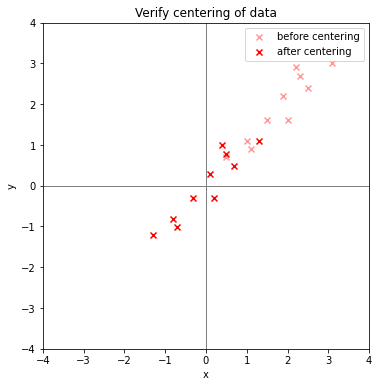

In [112]:
def format_plot(xlabel='x', ylabel='y'):
    """
    Function to group common plot formatting.
    """
    ax = plt.gca()
    ax.set_aspect('equal')
    ax.axhline(0, color='gray', linewidth=1)
    ax.axvline(0, color='gray', linewidth=1)
    plt.xlim((-4,4))
    plt.ylim((-4,4))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    

# Test 1
print(f"""
Test #1
Verify sample covariance matrix S.
Expected: symmetric matrix.
Actual: \n{S}
""")

# Test 2
print(f"""
Test #2
Verify eigen values are sorted properly.
Expected: descending order (largest first).
Actual: \n{eigvalues}
""")

# Test 3
print("""
Test #3
Visual verification that data is centered
""")
plt.figure(figsize=(6, 6))
plt.scatter(raw_data.x, raw_data.y, marker='x', c='red', label='before centering', alpha=0.4)
plt.scatter(data.x, data.y, marker='x', c='red', label='after centering')
format_plot()
plt.title('Verify centering of data')
plt.legend()
plt.show()

Now that we have the eigenvectors, we can see how they relate to the datapoints. We expect the first vector to be in the direction that would capture the most variance.

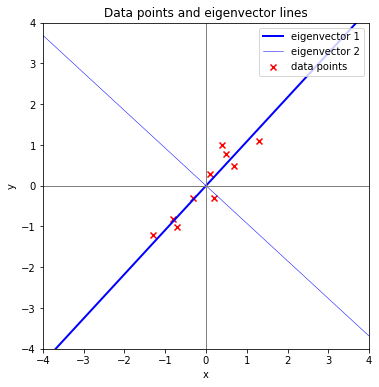

In [113]:
# Plot data points and eigenvector lines
def plot_eigvectors(eigvectors):
    """
    Plots the line where each of the eigen vector.
    """
    # first eigen vector
    x, y = eigvectors.T[0][0], eigvectors.T[0][1]
    plt.axline((0, 0), (x, y), color='b', label=f'eigenvector 1', linewidth=2)
    
    # second eigen vector
    x, y = eigvectors.T[1][0], eigvectors.T[1][1]
    plt.axline((0, 0), (x, y), color='b', label=f'eigenvector 2', linewidth=0.5)
        
def plot_data(data):
    """
    Simple function to plot the data. Used to abstract the algorithm in the code.
    """
    plt.scatter(data.x, data.y, marker='x', c='red', label='data points')


plt.figure(figsize=(6, 6))
plot_eigvectors(eigvectors)
plot_data(data)
format_plot()
plt.title('Data points and eigenvector lines')
plt.legend()
plt.show()

We are finally getting to the core of PCA, now it is getting interesting.

Lets find the principle components (identical to the ordered eigenvectors) and transform the data that is derive the new dataset.

Note: The matrix with principle compoents in columns is called **feature vector**. If the vectors are in the rows - it is called row feature vector instead.

In [114]:
# Data in terms of the principle components
components = (eigvectors[:,[0]], eigvectors[:,[1]])

# Transformed data with new basis - both principle components
final = data @ eigvectors

We can plot the original data against the two principle components. This is a simple change of basis. However, using PCA we ensure the greatest variation of the points is captured (the spread along x axis in this case).

If you look closely you will notice that the data is flipped along the second eigenvector. I suspect this is caused by the selection of the eigen vectors, more specifically - their directions. To be confirmed.

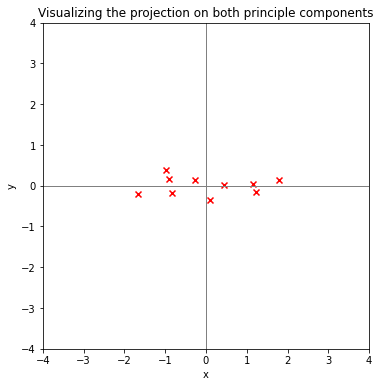

In [115]:
# Plot the data points along the eigenvector axes
plt.figure(figsize=(6, 6))
plt.scatter(final[0], final[1], marker='x', c='red', label='data points')
format_plot()
plt.title('Visualizing the projection on both principle components')
plt.show()

Projecting on all principle components (in this example - 2 pcs) is not PCA is about though. When PCA is used to reduce the dimensions (or number of features) in a dataset, we select some (small number) of components. In this particular example, lets project on the first principle component that is the first column of the feature vector. The data will become 1-dimensional (points on a line).

Lets plot both cases - using both or only the first compoent.

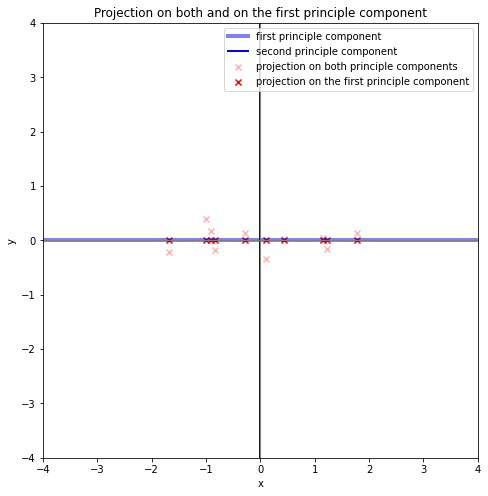

In [117]:
# Projecting on the first principle component
reduced = data @ components[0]

# Plot the result
plt.figure(figsize=(8, 8))
plt.axhline(0, color='b', label=f'first principle component', linewidth=4, alpha=0.5)
plt.axvline(0, color='b', label=f'second principle component', linewidth=2)

plt.scatter(final[0], final[1], marker='x', c='red', label='projection on both principle components', alpha=0.3)
plt.scatter(reduced, np.zeros(reduced.size), marker='x', c='red', label='projection on the first principle component')

format_plot()
plt.title('Projection on both and on the first principle component')
plt.legend()
plt.show()

Finally, to see the final result, lets plot the data before and after PCA.

With this, we conclude this example.

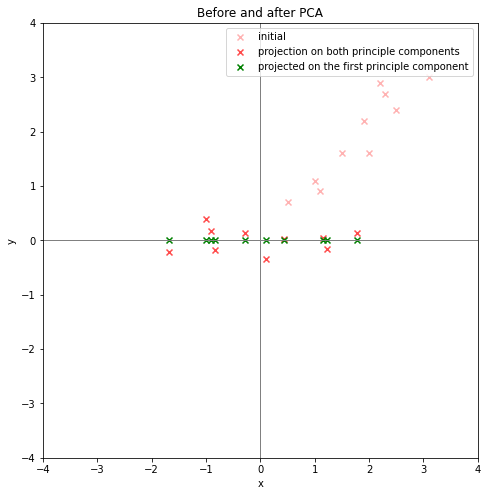

In [118]:
plt.figure(figsize=(8, 8))

plt.scatter(raw_data.x, raw_data.y, marker='x', c='red', label='initial', alpha=0.3)
plt.scatter(final[0], final[1], marker='x', c='red', label='projection on both principle components', alpha=0.7)
plt.scatter(reduced, np.zeros(reduced.size), marker='x', c='green', label='projected on the first principle component')

format_plot()
plt.title('Before and after PCA')
plt.legend()
plt.show()

### Comparison to sklearn

Below is a condensed version of our custom algorithm. It is then compared to the one build in `sklearn.decomposition`.

Few words about how `sklearn.decomposition.PCA()` functions. `PCA` is a python *class* thus it gets instantiated. The new object represents the *model* of pca. The syntax (or interface) first reminded me of the pyplot *state-based* interface that `matplotlib.pyplot` uses (more on the topic [here](https://matplotlib.org/matplotblog/posts/pyplot-vs-object-oriented-interface/)).

`sklearn.decomposition.PCA()` has required paramter - the number of principle components the *model* shall have. To create the model we *fit* it to our data; the `fit()` *method* can be used. We can then transform (=apply PCA to any data) using another method - `transform()`. However, for demonstration purposes we want to create a PCA model and transofr the original data. Therefore, we use the `fit_transoform()` method to combine these two actions.

Full details on `sklearn.decomposition.PCA()`: [here](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html).

In [121]:
def custom_pca(data, n=0):
    """
    Returns the transformed `data` after PCA.
    `data` - matrix, 2d aray 
    `n` - 0 for projecting on the first principle component, 1 for both components
    """
    # Center data
    means = data.mean()
    data = data - means

    # Sample covariance matrix
    row_num = data.shape[0]
    S = data.T @ data / (row_num - 1)
    
    eigvalues, eigvectors = np.linalg.eig(S)
    order = eigvalues.argsort()[::-1]
    eigvalues = eigvalues[order]
    eigvectors = eigvectors[:, order]
    
    # Data in terms of the principle components
    components = (eigvectors[:,[0]], eigvectors[:,[1]])

    # Transformed data with new basis - both principle components
    final = data @ components[n]

    return final


Test #1
Visual comparison between custom and build-in pca algorithms.
Expected: overlapping plots.
Actual:


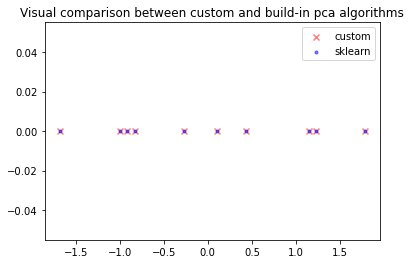


Test #2
Verify results from custom and build-in pca are equal.
Expected: differences are 0.
Actual: 
     0
0 -0.0
1  0.0
2 -0.0
3 -0.0
4 -0.0
5 -0.0
6 -0.0
7 -0.0
8 -0.0
9 -0.0



In [123]:
data = pd.DataFrame([
    [2.5, 2.4],
    [0.5, 0.7],
    [2.2, 2.9],
    [1.9, 2.2],
    [3.1, 3. ],
    [2.3, 2.7],
    [2. , 1.6],
    [1. , 1.1],
    [1.5, 1.6],
    [1.1, 0.9],
])

# Custom function
result1 = custom_pca(data, 0)

# sklean.decomposition.PCA()
pca = decomposition.PCA(n_components=1)
result2 = pca.fit_transform(data)


# Test
print(f"""
Test #1
Visual comparison between custom and build-in pca algorithms.
Expected: overlapping plots.
Actual:""")
plt.scatter(result1, np.zeros_like(result1), marker='x', c='red', label='custom', alpha=0.5)
plt.scatter(result2, np.zeros_like(result2), marker='.', c='blue', label='sklearn', alpha=0.5)
plt.legend()
plt.title('Visual comparison between custom and build-in pca algorithms')
plt.show()

differences = result1 - result2
print(f"""
Test #2
Verify results from custom and build-in pca are equal.
Expected: differences are 0.
Actual: \n{differences.round(10)}
""")

### The Iris dataset

From this point on, we will not bother using the custom PCA function but instead use the [build-in PCA class](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) from sklearn. Using a buildin class is much easier at is abstracts PCA - we no longer care HOW the algorithm works but rather care WHAT we receive as a result. This hides the complexity and allow us to focus on applying PCA rather than understaning all the maths every time.

Note that we are dealing with class and not  function even though this is not immediately clear. As most classes, it has parameters when instanciated, but it also has attributes (such as `singular_values_` and `explained_variance_`) that we can call using the dot notation.
Finally, there are also methods e.g. `fit()` or `fit_transform`: the first fits the model with X, the second - fits and projects (reduces the dimensions of) X.

The worked problem below is based on this [example](https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html?highlight=pca) from scikit-learn homepage. 
It is about the iris flower. Its parts called sepal and petal are measured, 4 dimensions (features) in total.

<div>
<img src="https://www.embedded-robotics.com/wp-content/uploads/2022/01/Iris-Dataset-Classification.png" width="800"/>
</div>

Image is from [here](https://www.embedded-robotics.com/iris-dataset-classification/).


To provide some more context, below is the example description:

>This data sets consists of 3 different types of irises’ (Setosa, Versicolour, and Virginica) petal and sepal length, stored in a 150x4 numpy.ndarray.
>The rows being the samples and the columns being: Sepal Length, Sepal Width, Petal Length and Petal Width.

In [185]:
iris = datasets.load_iris()
X = iris.data
X.shape

(150, 4)

In [186]:
y = iris.target
y.shape

(150,)

Next, we plot the data `X` that we will use to train the PCA model. "Traning" means to generate the vectors, the principle components, that decompose `X`.

Do not get scared by the fancy plotting parameters in the next 2 code cells - it is all to make the 3d plot below pretty. 

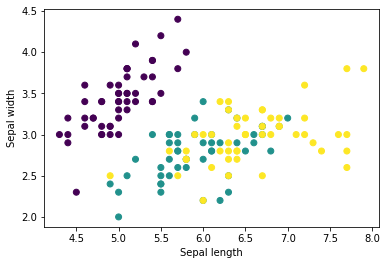

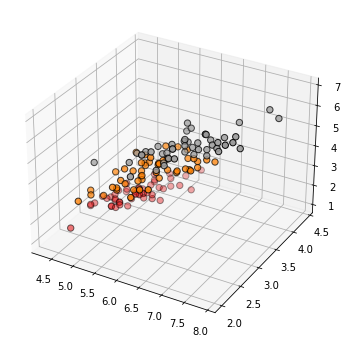

In [187]:
# Plot the training points
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.xlabel("Sepal length")
plt.ylabel("Sepal width")
plt.show()

fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    X[:, 0],
    X[:, 1],
    X[:, 2],
    c=y,
    cmap=plt.cm.Set1,
    edgecolor="k",
    s=40,
)
plt.show()

The essence of what is done is the build-in PCA class that we use:

```python
X_reduced = PCA(n_components=3).fit_transform(iris.data)
```

Also note, that the `c='y'` is not the same as `c=y`. The former one is setting one color to yellow. What we are acutally doing is assiging our target `y` defined above to the color parameter. This groups the data and gives each group a seperate color.

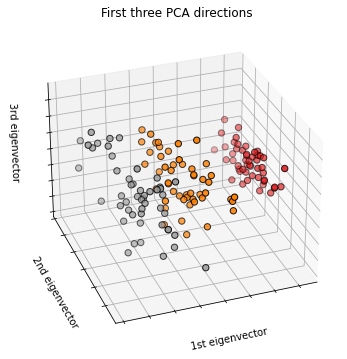

In [188]:
# To getter a better understanding of interaction of the dimensions
# plot the first three PCA dimensions
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d", elev=-150, azim=110)

X_reduced = PCA(n_components=3).fit_transform(iris.data)
ax.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    X_reduced[:, 2],
    c=y,
    cmap=plt.cm.Set1,
    edgecolor="k",
    s=40,
)

ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

plt.show()

We can also project using the first two or just one components:

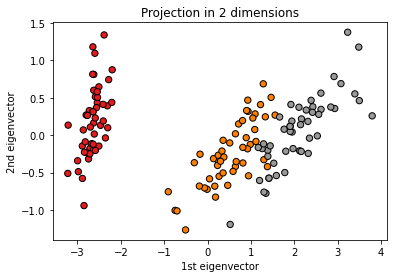

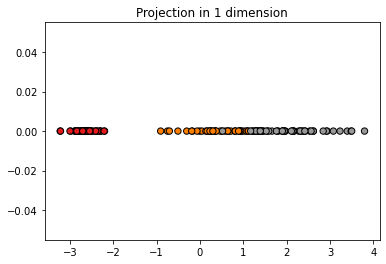

In [189]:
plt.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    c=y,
    cmap=plt.cm.Set1,
    edgecolor="k",
    s=40,
)

plt.title("Projection in 2 dimensions")
plt.xlabel("1st eigenvector")
plt.ylabel("2nd eigenvector")
plt.show()


plt.scatter(
    X_reduced[:, 0],
    np.zeros_like(X_reduced[:, 0]),
    c=y,
    cmap=plt.cm.Set1,
    edgecolor="k",
    s=40,
)
plt.title("Projection in 1 dimension")
plt.show()

What we can also do is explore the the sklearn PCA object capabilities.

Quote from the [documentation](https://scikit-learn.org/stable/modules/decomposition.html#pca):
>In scikit-learn, PCA is implemented as a transformer object that learns  components in its fit method, and can be used on new data to project it on these components. PCA centers but does not scale the input data for each feature before applying the SVD.

In [161]:
pca = PCA(n_components=3).fit(iris.data)
pca

PCA(n_components=3)

In [165]:
pca.components_

array([[ 0.36138659, -0.08452251,  0.85667061,  0.3582892 ],
       [ 0.65658877,  0.73016143, -0.17337266, -0.07548102],
       [-0.58202985,  0.59791083,  0.07623608,  0.54583143]])

In [168]:
pca.n_components_

3

In [169]:
pca.n_features_

4

In [170]:
pca.n_samples_

150

In [171]:
pca.singular_values_

array([25.09996044,  6.01314738,  3.41368064])

In [172]:
pca.svd_solver

'auto'

The **total variance** is the sum of all eigenvalues (which in the PCA contex also means the sample variances). This sum is also the trace of the $\Sigma$ matrix:

$$\sigma_1^2 + \sigma_2^2 + \dots + \sigma_m^2 \text{ (eigen values)} = \text{trace of }\Sigma  = s_1^2 + s_2^2 + \dots + s_m^2 \text{ (sample covariances)}$$

Let's calculate it.

In [200]:
total_var = np.sum(pca.singular_values_ ** 2)
total_var

677.8191711469566

In PCA we usually project the data using only the first several eigen values (or sample variances) that explain most of the data. The ratio of the used variance / total variance is called **explained variance**.

Explained variance is a measure of the **discrepancy** between the model and actual data.

Let's calculate the explained variance manually and then compare to the value of the sklean pca object attribute.

In [212]:
explained_var = np.array([(value ** 2 / total_var) for value in pca.singular_values_])
explained_var_cum = np.cumsum(explained_var)

# Comparison
# Test: expected equal values
explained_var, pca.explained_variance_ratio_

(array([0.92946326, 0.05334452, 0.01719222]),
 array([0.92461872, 0.05306648, 0.01710261]))

Finally, lets plot the explain variance.

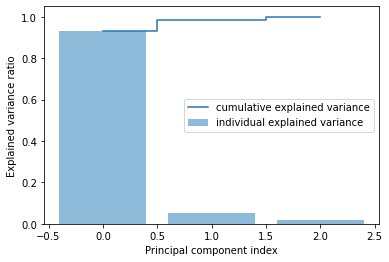

In [214]:
# Plot explained variances
plt.bar(range(3), explained_var, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(3), explained_var_cum, where='mid', label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend()
plt.show()

### Eigenfaces

Finally, let's scratch the surface of an interesting application of PCA: eigenfaces. The eigenfaces problem is basically using PCA to recognize images of human faces.

PCA needs matrices, and we have multiple images. A color 100x100 image is an array 100 x 100 x 3. The "3" is needed beacause we have one value for each color channel: Red, Green, Blue. To make our lives easier, the images we are about to use are monochrome (think of black-white photos), meaning they have a single channel. Thus, the array becomes 100x100x1, that is in fact a 2D 100x100 matrix, where the value represents the single "gray" channel.

Each image is a sample, a record. But it is 2D at the moment. What we do is to slice the rows of pixels and 'stick' them in order. Thus, 100 x 100 matrix, turns into a VECTOR with 10000 components. Each of these 10000 pixel values is one feature, one dimension.

Pixels values shall first be normalized, that is scaled to a number between 0 and 1.

Images are freely available from [here](https://www.kaggle.com/datasets/kasikrit/att-database-of-faces).

In [223]:
# Load images
base_directory = './faces'
pattern = '**/*.pgm'

images = []
entries = pathlib.Path(base_directory).glob(pattern)
for entry in entries:
    images.append(skimage.io.imread(entry))

images = np.asarray(images)
images.shape

(400, 112, 92)

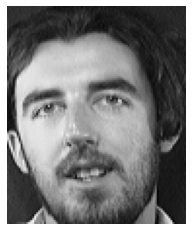

In [224]:
# Display a random image from the set
plt.imshow(images[22,:,:], cmap='gray')
plt.axis('off')
plt.show()

In [225]:
# Transform images to 1D columns
n_images, h, w = images.shape
n_features = h * w

faces = images.reshape(n_images, n_features)
faces = faces.T

In [226]:
n_components = 3
faces_centered = faces - faces.mean(axis=0)
pca_estimator = decomposition.PCA(n_components=n_components)
reduced2 = pca_estimator.fit_transform(faces_centered)
reduced2.shape

(10304, 3)

In [227]:
final = reduced.T
final = final.reshape(n_components, h, w)

for i in range(n_components):
    plt.imshow(final[i,:,:], cmap='gray')
    plt.axis('off')
    plt.title(f'Image {i}')
    plt.show()

plt.imshow(final.mean(axis=0), cmap='gray')
plt.axis('off')
plt.title('Mean image')
plt.show()

AttributeError: 'DataFrame' object has no attribute 'reshape'

In [ ]:
n_components = 3
reduced = PCA(n_components=n_components).fit_transform(images_hstacked)
reduced.shape

In [222]:
final = reduced.T
final = final.reshape(n_components, h, w)

for i in range(n_components):
    plt.imshow(final[i,:,:], cmap='gray')
    plt.axis('off')
    plt.title(f'Image {i}')
    plt.show()

plt.imshow(final.mean(axis=0), cmap='gray')
plt.axis('off')
plt.title('Mean image')
plt.show()

AttributeError: 'DataFrame' object has no attribute 'reshape'

## 4. Appendix

### References
[MIT Linear algebra lectures](https://ocw.mit.edu/courses/18-06-linear-algebra-spring-2010/video_galleries/video-lectures/)

[PCA article 1](https://towardsdatascience.com/principal-component-analysis-for-dimensionality-reduction-115a3d157bad)

[PCA article 2](https://www.kdnuggets.com/2020/05/dimensionality-reduction-principal-component-analysis.html)

[PCA article 3](http://web.math.ucsb.edu/~atzberg/pmwiki_intranet/uploads/AtzbergerHomePage/ml_lecture_Dimension_Reduction_Atzberger.pdf)

[Good explanation of SVD](https://jonathan-hui.medium.com/machine-learning-singular-value-decomposition-svd-principal-component-analysis-pca-1d45e885e491).

[Eigenfaces worked example from scikit-learn](https://scikit-learn.org/stable/auto_examples/decomposition/plot_faces_decomposition.html?highlight=pca%20example)

[Interactive Demo](https://setosa.io/ev/principal-component-analysis/)

### Unfinished example: Wines

The problem is based on [this](https://towardsdatascience.com/principal-component-analysis-for-dimensionality-reduction-115a3d157bad) tutorial. 

#### My adaptation

I am using [this](https://towardsdatascience.com/principal-component-analysis-for-dimensionality-reduction-115a3d157bad) tutorial. However, I simplified the algorith and used more descriptive varaible names. The original version is further below. Data is freely available from [here](https://archive.ics.uci.edu/ml/machine-learning-databases/wine).

In [173]:
# Read data
wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
wine.shape

(178, 14)

In [174]:
data = wine.iloc[:, 1:].values
# target = wine.iloc[:, :1].values

# Normalize data
s = data.std(axis=0)
x_bar = data.mean(axis=0)
data_std = (data - x_bar) / s

# Find covariance matrix
covariance_matrix = data_std.T @ data_std

# Find eigen values and vectors
eigen_vals, eigen_vecs = np.linalg.eig(covariance_matrix)

The **total variance** is the sum of all eigenvalues (which in the PCA contex also means the sample variances). This sum is also the trace of the $\Sigma$ matrix:

$$\sigma_1^2 + \sigma_2^2 + \dots + \sigma_m^2 \text{ (eigen values)} = \text{trace of }\Sigma  = s_1^2 + s_2^2 + \dots + s_m^2 \text{ (sample covariances)}$$

In PCA we usually project the data using only the first several eigen values (or sample variances) that explain most of the data. The ratio of the used variance / total variance is called **explained variance**.

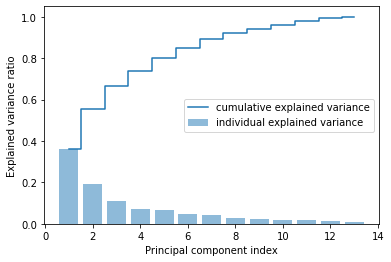

In [175]:
# Calculate cumulative sum of explained variances
total = sum(eigen_vals)
explained_var = [(value / total) for value in sorted(eigen_vals, reverse=True)]
explained_var_cum = np.cumsum(explained_var)

# Plot explained variances
plt.bar(range(1,14), explained_var, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1,14), explained_var_cum, where='mid', label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend()
plt.show()

As stated before, **explained variance** is a measure of the **discrepancy** between the model and actual data. For example, if we make the model using the first 3 the first three principle components, the percentage of variation we will cover (that is the total explained variance will be ~ 66%.

In [176]:
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

# Select first two princple components
pc = [
    eigen_pairs[0][1][:, np.newaxis],
    eigen_pairs[1][1][:, np.newaxis],
]
proj_matrix = np.hstack(pc)

# Test
print(f"Verifying projection matrix shape. \nExpected: (13, 2)\nActual: {proj_matrix.shape}")

Verifying projection matrix shape. 
Expected: (13, 2)
Actual: (13, 2)


`[:, np.newaxis]` is used to transform the row vector to column vector, that is to **transpose it**.

In [177]:
# Transform 
wine_pca = data_std.dot(proj_matrix)

# Test
wine_pca.shape, data_std.shape  # expected ((178, 2), (178, 13))

((178, 2), (178, 13))

Finally, we plot the transformed data. The data has now only 2 indead of 13 features (columns). It is compressed that is projected on the two new axes: principle component 1 and 2.

The target or the output is the wine sort (variaty) 

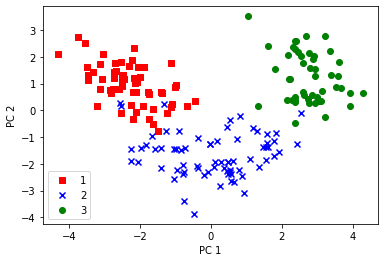

In [178]:
# Plot
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

target = wine.iloc[:, 0].values
for l, c, m in zip(np.unique(target), colors, markers):
    x = wine_pca[target==l, 0]
    y = wine_pca[target==l, 1]
    plt.scatter(x, y, c=c, label=l, marker=m)

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.show()

#### Original code

The original code from the article splits the data in two. **Train data** is used to generate the PCA projection matrix (=**fit the model**); it contains 124 rows. Then, the already created **model** is used to **predict** the type of wine of the remaining **train data** based on the two new features (=principle components). Of course, the train data is part of the initial dataset so we **know** the type of wine. Therefore we can compare what the model **predicts** to reality.

**Note:** since the code below uses only part of the dataset to create the model, the plots below (especially the second one - princple components) differ from my adaptation above. 

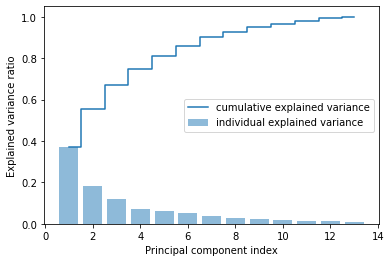

In [179]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)

# split into training and testing sets
X = df_wine.iloc[:, 1:].values
y = df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

# Standardize the features
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

# Calculate covariance matrix
cov_mat = np.cov(X_train_std.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

# Calculate cumulative sum of explained variances
total = sum(eigen_vals)
var_exp = [(i / total) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

# plot explained variances
plt.bar(range(1,14), var_exp, alpha=0.5,
        align='center', label='individual explained variance')
plt.step(range(1,14), cum_var_exp, where='mid',
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.show()

In [180]:
# Test to check the shapes of the test and train sets
for i in [X_train, X_test, y_train, y_test]:
    print(i.shape)

(124, 13)
(54, 13)
(124,)
(54,)


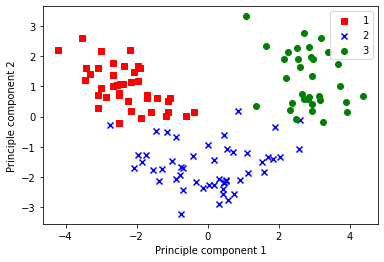

In [181]:
# Generate PCA matrix and project training data
def sort_eigen(vals, vecs):
    """
    Returns sorted eigenvalues and eigenvectors.
    Descending order of the eigenvalues (largest first).
    """
    order = vals.argsort()[::-1]
    return (vals[order], vecs[:, order])

sorted_vals, sorted_vecs = sort_eigen(eigen_vals, eigen_vecs)
pca_matrix = sorted_vecs[:,:2]
X_train_pca = X_train_std.dot(pca_matrix)

colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train==l, 0], 
                X_train_pca[y_train==l, 1], 
                c=c, label=l, marker=m) 
plt.xlabel('Principle component 1')
plt.ylabel('Principle component 2')
plt.legend()
plt.show()

### Self-assessment
The numbers in brackets define possible points for the corresponding item.

1. Problem statement (0-10) 9
	* How well is the problem defined?
    The topic is clear and defined at the start.
	* Does the research address a real-life problem?
    Yes, PCA is widely used algorithm.
	* Does the research solve the correct problem?
    Yes.

2. Layout (0-20) 15
	* Are the document sections structured properly?
    Overall, I feel it is fine compared to other notebooks I've seen. However, there are things I see I can improve: text cells shall be shorter and more to the point, text format shall better express my intensions...
	* Is the article well-formatted (in terms of readability)?
    7.5/10

3. Code quality (0-20) 14
	* Is the code well-written? Is the code self-documenting?
    I have tried.
	* Is the code organized into functions?
    I have tried.
	* Is the code generally well-structured?
    I have tried.

4. Previous research (0-10) 9
	* Have you cited at least two other sources?
    Yes
	* Does the project contain comparisons between the current and the previous results?
    There are some comparisons, yes.
   
5. Gathering / generating, cleaning, and formatting data (0-10) 8
	* Every problem deals with "real-world" data in some way. Even if you don't use datasets, you'll likely generate some data
	* How is the data gathered?
	* Is the process statistically valid?
	* Is the process of data acquisition, data cleaning, and data manipulation well documented?

6. Testing (0-10) 8
	* This can have various meanings: unit testing, hypothesis testing, train / test data set, etc.
	* Is the code thoroughly tested?
	* Are there any comparisons to other implementations / other articles / previous research?

7. Visualization (0-10) 8
	* All kinds of projects employ some visualization: graphical plots, tables, etc.
	* Are all visualizations correct (i.e. convey the intended meaning without misleading the intended audience)?
	* Are all visualizations clear, and easy to understand?

8. Communication (0-10) 7
	* Does the project tell the story correctly?
    This takes most of the effort and time, ideally i want it to be better structored.
	* Does the project serve the audience it was intended for?